## Predicting real part of dielectric function with GNNOpt from crystal structures

### Getting started

In [53]:
import os 
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score)
from utils.utils_model import Network, visualize_layers, train

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

torch device: cuda:0


### Data provenance
We train our model using the database of High-throughput optical absorption spectra for inorganic semiconductors [[Yang et al. 2018]](https://arxiv.org/pdf/2209.02918.pdf) from the Materials Project. Independent-particle approximation and containing 944 crystalline solids with number of atoms in cell < 10.

In [54]:
data_file = './data/absorption_mp_data.pkl'
df, species = load_data(data_file)
df.head()

,id,formula,structure,energies,absorption_coefficient,imag_dielectric,real_dielectric,energy_max,bandgap,species
0,mp-546266,DyBi2IO4,"(Atom('Dy', [0.0, 0.0, 0.0], index=0), Atom('B...","[0.0, 0.0277, 0.0554, 0.0831, 0.1109, 0.1386, ...","[0.0, 0.8362304735329499, 3.309178082718349, 7...","[0.0, 0.0015666666666666665, 0.0031, 0.0046666...","[6.9163, 6.916533333333334, 6.9172, 6.9182, 6....",55.4328,1.3818000000000001,"[O, I, Dy, Bi]"
1,mp-9583,K2ZnF4,"(Atom('K', [1.2531985199117757, 1.368027219932...","[0.0, 0.0399, 0.0798, 0.1197, 0.1596, 0.1995, ...","[0.0, 0.1362578822994739, 0.4541860898852432, ...","[0.0, 0.0001, 0.00016666666666666666, 0.0002, ...","[2.2021333333333333, 2.202166666666667, 2.2022...",79.7804,4.3866,"[Zn, F, K]"
2,mp-22988,CsGeCl3,"(Atom('Cs', [7.78333021211009, 0.0, 5.48124386...","[0.0, 0.029, 0.058, 0.087, 0.116, 0.1449, 0.17...","[0.0, 0.515935972729374, 2.0145311056971553, 4...","[0.0, 0.0007, 0.0013666666666666669, 0.0020333...","[3.975733333333333, 3.9758333333333336, 3.9761...",57.9759,2.178,"[Cs, Ge, Cl]"
3,mp-861502,AcFeO3,"(Atom('Ac', [0.0, 0.0, 0.0], index=0), Atom('F...","[0.0, 0.0587, 0.1174, 0.176, 0.2347, 0.2934, 0...","[0.0, 11295.053197761259, 44864.495977063896, ...","[0.0, 30.1914, 49.9196, 37.98413333333333, 21....","[67.54320000000001, 59.6215, 29.6067, 1.281, -...",117.3625,0.0,"[Fe, O, Ac]"
4,mp-1025029,PrHSe,"(Atom('Pr', [-2.0265362, -1.17002398670996, -6...","[0.0, 0.0365, 0.073, 0.1095, 0.1459, 0.1824, 0...","[0.0, 1.6849892209331498, 6.697792903781345, 1...","[0.0, 0.0026999999999999997, 0.005366666666666...","[8.784633333333334, 8.7851, 8.786566666666667,...",72.9718,1.9455999999999998,"[Pr, H, Se]"


### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

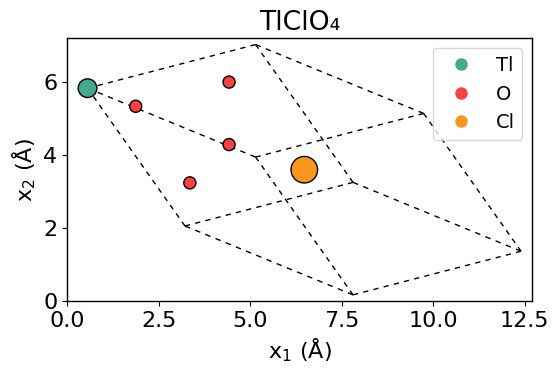

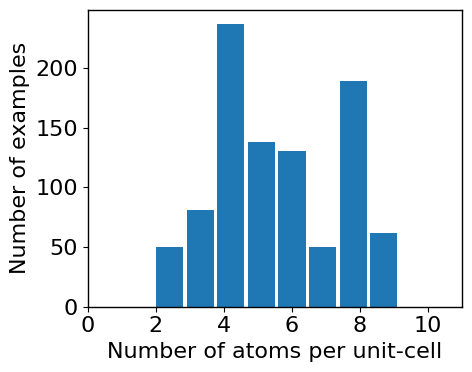

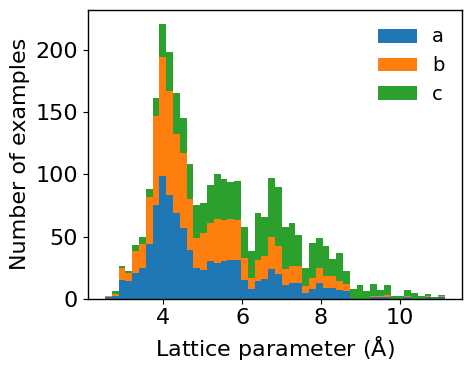

In [55]:
# plot an example structure
i = 16 # structure index in dataframe
struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

# Create the plot
fig, ax = plt.subplots(figsize=(6,6))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('45x,45y,0z'))

# Add legend with atom labels
legend_elements = []
for symbol, color in zip(set(symbols), [cmap(norm(i)) for i in range(len(set(symbols)))]):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=symbol, markerfacecolor=color, markersize=10))
ax.legend(handles=legend_elements, loc='upper right')

# Set labels and title
ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$')
ax.set_title(df.iloc[i]['formula'].translate(sub), fontname='DejaVu Sans')

# data statistics (#Atoms/cell)
sites = [len(s.get_positions()) for s in list(df['structure'])]
fig, ax = plt.subplots(figsize=(5,4))
ax.hist(sites, bins=max(sites), fc='#2ab0ff', ec='#e0e0e0', lw=1, width=0.8)
ax.set_xlim(0.0, 11)
x_ticks = np.arange(0, 12, 2) 
ax.set_xticks(x_ticks)
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of atoms per unit-cell')
fig.patch.set_facecolor('white')
plt.tight_layout()
#fig.savefig('data-site.pdf')

# bandgap = np.array(df['bandgap'])
# fig, ax = plt.subplots(figsize=(5,4))
# ax.hist(bandgap, bins=50, fc='#2ab0ff', ec='#e0e0e0')
# ax.set_xlim(-0.5, 5.5)
# x_ticks = np.arange(0, 6, 1) 
# ax.set_xticks(x_ticks)
# ax.set_xlabel('Energy band gap (eV)')
# ax.set_ylabel('Number of examples')
# fig.patch.set_facecolor('white')
# plt.tight_layout()
#fig.savefig('data-bandgap.pdf')

# lattice parameter statistics
def get_lattice_parameters(data):
    a = []
    len_data = len(data)
    for i in range(len_data):
        d = data.iloc[i]
        a.append(d.structure.cell.cellpar()[:3])
    return np.stack(a)
a = get_lattice_parameters(df)

fig, ax = plt.subplots(figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Lattice parameter ($\AA$)')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)
plt.tight_layout()
#fig.savefig('data-lattice.pdf')
#print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

# Show the plot
plt.show()

### Reconstruction data

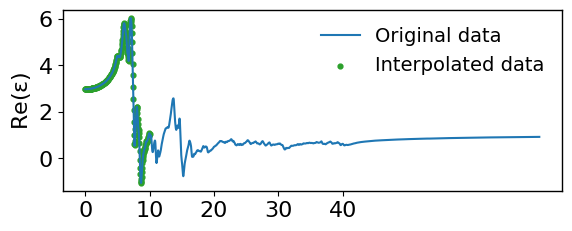

In [56]:
energy_min = 0.0 #Unit of energy in eV
energy_max = 10 #Unit of energy in eV
nstep = 251 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate(row, column):
    interp = interp1d(row['energies'], row[column], kind='linear', fill_value=0, bounds_error=False)
    new_y = interp(new_x)
    return new_y

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)
df['real_dielectric_interp'] = df.apply(lambda row: interpolate(row, 'real_dielectric'), axis=1)


# Show the plot for compare the original data and interpolated data
plt.figure(figsize=(6, 7))

plt.subplot(3, 1, 2)
plt.plot(df['energies'][i], df['real_dielectric'][i], label='Original data')
plt.scatter(df['energies_interp'][i], df['real_dielectric_interp'][i], s=12, marker ='o', alpha=1, color='C2', label='Interpolated data')
x_ticks = np.arange(0, 50, 10) 
plt.xticks(x_ticks)
plt.xlabel('')
plt.ylabel(r'Re($\varepsilon$)')
plt.legend(frameon=False)


plt.tight_layout()
#plt.savefig('data-interpolation.pdf')
plt.show()

In [57]:
tmp = np.array([df.iloc[i]['real_dielectric'] for i in range(len(df))])
scale_data = np.median(np.max(tmp, axis=1))

### Feature representation

In [58]:

def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius

def save_or_load_onehot(save_path="./onehot_data"):
    # Define file paths
    type_onehot_path = os.path.join(save_path, "type_onehot.torch")
    mass_onehot_path = os.path.join(save_path, "mass_onehot.torch")
    dipole_onehot_path = os.path.join(save_path, "dipole_onehot.torch")
    radius_onehot_path = os.path.join(save_path, "radius_onehot.torch")
    encoding_path = os.path.join(save_path, "type_encoding.torch")

    # Check if data already exists
    if all(os.path.exists(path) for path in [type_onehot_path, mass_onehot_path, dipole_onehot_path, radius_onehot_path, encoding_path]):
        print("Loading existing data...")
        type_onehot = torch.load(type_onehot_path)
        mass_onehot = torch.load(mass_onehot_path)
        dipole_onehot = torch.load(dipole_onehot_path)
        radius_onehot = torch.load(radius_onehot_path)
        type_encoding = torch.load(encoding_path)
    else:
        print("Processing data...")
        type_encoding = {}
        specie_mass = []
        specie_dipole = []
        specie_radius = []

        for Z in tqdm(range(1, 119), desc="Processing Elements"):
            symbol, encoding, mass, dipole, radius = process_atom(Z)
            type_encoding[symbol] = encoding
            specie_mass.append(mass)
            specie_dipole.append(dipole)
            specie_radius.append(radius)

        # Convert to one-hot encodings
        type_onehot = torch.eye(len(type_encoding))
        mass_onehot = torch.diag(torch.tensor(specie_mass))
        dipole_onehot = torch.diag(torch.tensor(specie_dipole))
        radius_onehot = torch.diag(torch.tensor(specie_radius))

        # Save the data
        os.makedirs(save_path, exist_ok=True)
        torch.save(type_onehot, type_onehot_path)
        torch.save(mass_onehot, mass_onehot_path)
        torch.save(dipole_onehot, dipole_onehot_path)
        torch.save(radius_onehot, radius_onehot_path)
        torch.save(type_encoding, encoding_path)
        print("Data saved!")

    return type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding

# Run the function
type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

Loading existing data...


In [59]:
# Find the scale value
tmp = np.array([df.iloc[i]['real_dielectric'] for i in range(len(df))])
scale_data = np.median(np.max(tmp, axis=1))
#print(scale_data)

# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=torch.from_numpy(entry.real_dielectric_interp/scale_data).unsqueeze(0)
    )
    
    return data

r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

  1%|▏         | 14/940 [00:00<00:07, 126.57it/s]

100%|██████████| 940/940 [00:08<00:00, 114.57it/s]


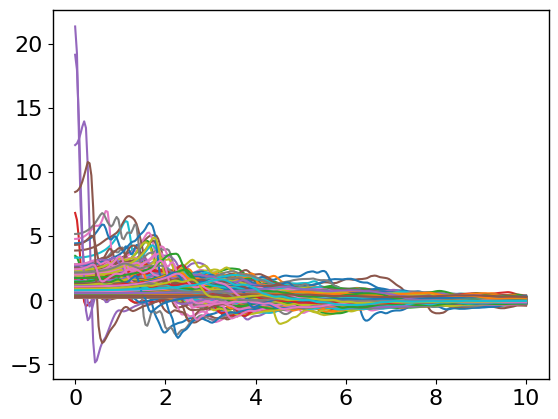

In [60]:
omega = df.iloc[0]['energies_interp']
for i in range(len(df)):
    plt.plot(omega, df['data'][i].y.reshape(-1))
plt.show()
# plot_example(df, i=i, label_edges=True)

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

split train/dev ...


100%|██████████| 81/81 [00:00<00:00, 632.65it/s]


split valid/test ...


100%|██████████| 79/79 [00:00<00:00, 726.70it/s]


number of training examples: 733
number of validation examples: 97
number of testing examples: 110
total number of examples: 940


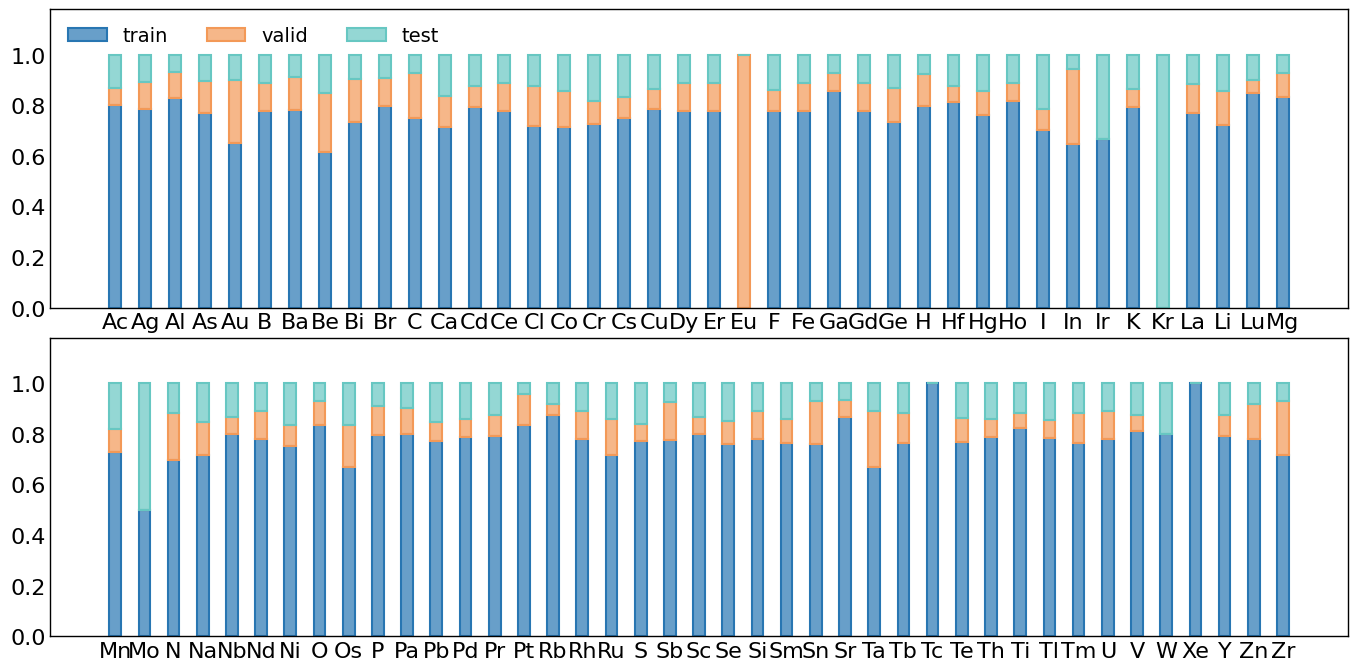

In [61]:
run_time = time.strftime('%y%m%d', time.localtime())
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)
#Save train loss values sets
np.savetxt('./model/idx_train_'+ run_time +'.txt', idx_train, fmt='%i', delimiter='\t')
np.savetxt('./model/idx_valid_'+ run_time +'.txt', idx_valid, fmt='%i', delimiter='\t')
np.savetxt('./model/idx_test_'+ run_time +'.txt', idx_test, fmt='%i', delimiter='\t')
# plt.savefig('data-split.pdf')

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [62]:
# load train/valid/test indices
with open('./model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('./model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('./model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 16
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 51.03625673689368 / 53.70992366412214 / 47.90437601296596


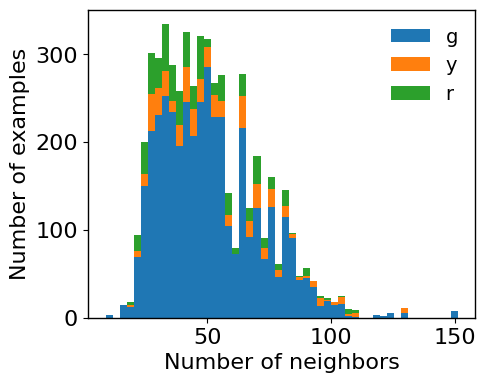

In [63]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data['pos'].shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [64]:
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)

In [65]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em_type = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_type(data.z))
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)      # stack the atom features in shape (3, N, em_dim) 
        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        data.x = data.x_radius
        output = super().forward(data)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        # normalization output from 0 to 1
        #maxima, _ = torch.max(output, dim=1)
        #output = output.div(maxima.unsqueeze(1))
        
        return output

In [66]:
out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64  

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=3,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=2,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 96x0e+32x1o+32x2e | 393216 paths | 393216 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 192]
        (tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 64x0e -> 96x0e+32x1o+32x2e | 655360 paths | 655360 weights)
      )
      (second): Gate (96x0e+32x1o+32x2e -> 32x0e+32x1o+32x2e)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 458752 paths | 458752 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 32x0e+32x1o+32x2e | 196608 paths | 196608 weights)
        (fc): FullyConnectedNet[10, 100, 

### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=0.05, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [68]:
run_name = 'model_re_trace_openmx_' + run_time
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name, 
       max_iter=100, scheduler=scheduler, device=device)

  2%|▏         | 1/46 [00:00<00:07,  6.36it/s]

100%|██████████| 46/46 [00:04<00:00,  9.65it/s]


New best validation loss: 0.2034. Saving model...
Iteration    1   train loss =   0.1797   valid loss =   0.2034   elapsed time = 00:00:04
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 21.47it/s]


New best validation loss: 0.1664. Saving model...
Iteration    2   train loss =   0.1403   valid loss =   0.1664   elapsed time = 00:00:08
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 21.58it/s]


New best validation loss: 0.1380. Saving model...
Iteration    3   train loss =   0.1085   valid loss =   0.1380   elapsed time = 00:00:11
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.15it/s]


New best validation loss: 0.1360. Saving model...
Iteration    4   train loss =   0.0997   valid loss =   0.1360   elapsed time = 00:00:14
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.28it/s]


New best validation loss: 0.1279. Saving model...
Iteration    5   train loss =   0.0865   valid loss =   0.1279   elapsed time = 00:00:17
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.26it/s]


New best validation loss: 0.1255. Saving model...
Iteration    7   train loss =   0.0857   valid loss =   0.1255   elapsed time = 00:00:23
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.43it/s]


New best validation loss: 0.1254. Saving model...
Iteration    9   train loss =   0.0845   valid loss =   0.1254   elapsed time = 00:00:28
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.44it/s]


New best validation loss: 0.1151. Saving model...
Iteration   11   train loss =   0.0712   valid loss =   0.1151   elapsed time = 00:00:33
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.25it/s]


New best validation loss: 0.1126. Saving model...
Iteration   14   train loss =   0.0755   valid loss =   0.1126   elapsed time = 00:00:41
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.29it/s]


New best validation loss: 0.1114. Saving model...
Iteration   17   train loss =   0.0591   valid loss =   0.1114   elapsed time = 00:00:48
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.16it/s]


New best validation loss: 0.1104. Saving model...
Iteration   21   train loss =   0.0451   valid loss =   0.1104   elapsed time = 00:00:57
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.35it/s]


New best validation loss: 0.1098. Saving model...
Iteration   25   train loss =   0.0412   valid loss =   0.1098   elapsed time = 00:01:06
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.44it/s]


Iteration   29   train loss =   0.0431   valid loss =   0.1102   elapsed time = 00:01:16
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.22it/s]


New best validation loss: 0.1072. Saving model...
Iteration   34   train loss =   0.0355   valid loss =   0.1072   elapsed time = 00:01:27
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.41it/s]


New best validation loss: 0.1062. Saving model...
Iteration   39   train loss =   0.0332   valid loss =   0.1062   elapsed time = 00:01:39
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.52it/s]


New best validation loss: 0.1060. Saving model...
Iteration   44   train loss =   0.0293   valid loss =   0.1060   elapsed time = 00:01:50
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.42it/s]


New best validation loss: 0.1051. Saving model...
Iteration   49   train loss =   0.0275   valid loss =   0.1051   elapsed time = 00:02:02
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.31it/s]


Iteration   54   train loss =   0.0266   valid loss =   0.1058   elapsed time = 00:02:13
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.46it/s]


Iteration   59   train loss =   0.0260   valid loss =   0.1063   elapsed time = 00:02:24
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.34it/s]


Iteration   64   train loss =   0.0253   valid loss =   0.1057   elapsed time = 00:02:35
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.41it/s]


Iteration   69   train loss =   0.0248   valid loss =   0.1061   elapsed time = 00:02:47
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.40it/s]


Iteration   74   train loss =   0.0245   valid loss =   0.1057   elapsed time = 00:02:58
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.48it/s]


Iteration   79   train loss =   0.0243   valid loss =   0.1059   elapsed time = 00:03:09
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.36it/s]


Iteration   84   train loss =   0.0240   valid loss =   0.1059   elapsed time = 00:03:20
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.38it/s]


Iteration   89   train loss =   0.0238   valid loss =   0.1061   elapsed time = 00:03:31
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.49it/s]


Iteration   94   train loss =   0.0236   valid loss =   0.1063   elapsed time = 00:03:43
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.43it/s]


Iteration   99   train loss =   0.0235   valid loss =   0.1062   elapsed time = 00:03:54
tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 46/46 [00:02<00:00, 22.21it/s]


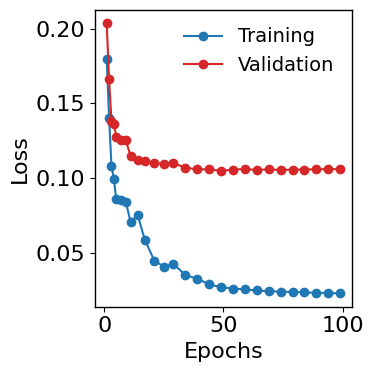

In [76]:
# load pre-trained model and plot its training history
#run_name = 'model_alpha_mass_' + run_time
history = torch.load('./model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

np.savetxt(run_name+'_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
# fig.savefig(run_name + '_loss.pdf')

### Results
We evaluate our model by visualizing the predicted and true optical spectra in each error quartile.

In [77]:
# predict on all data
model.load_state_dict(torch.load('./model/'+run_name + '_best.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['y_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

# weight contribution of each feature
weight = torch.abs(model.em_mixing.weight)/(torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True)+1e-10)
print(weight)

with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy() 
        df.loc[i0:i0 + len(d.y) - 1, 'y_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        i0 += len(d.y)
        
df['y_pred'] = df['y_pred'].map(lambda x: x[0])*scale_data

tensor([[0.0548, 0.5077, 0.4376]], device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 52.66it/s]


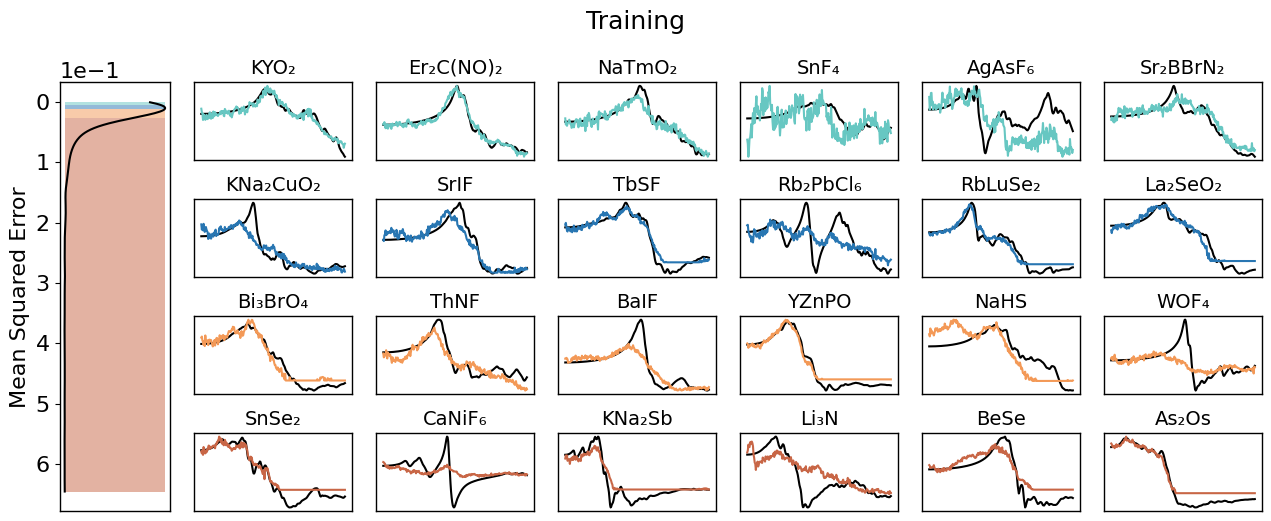

In [78]:
plot_predictions(df, idx_train, column='real_dielectric_interp', header=run_name, title='Training')

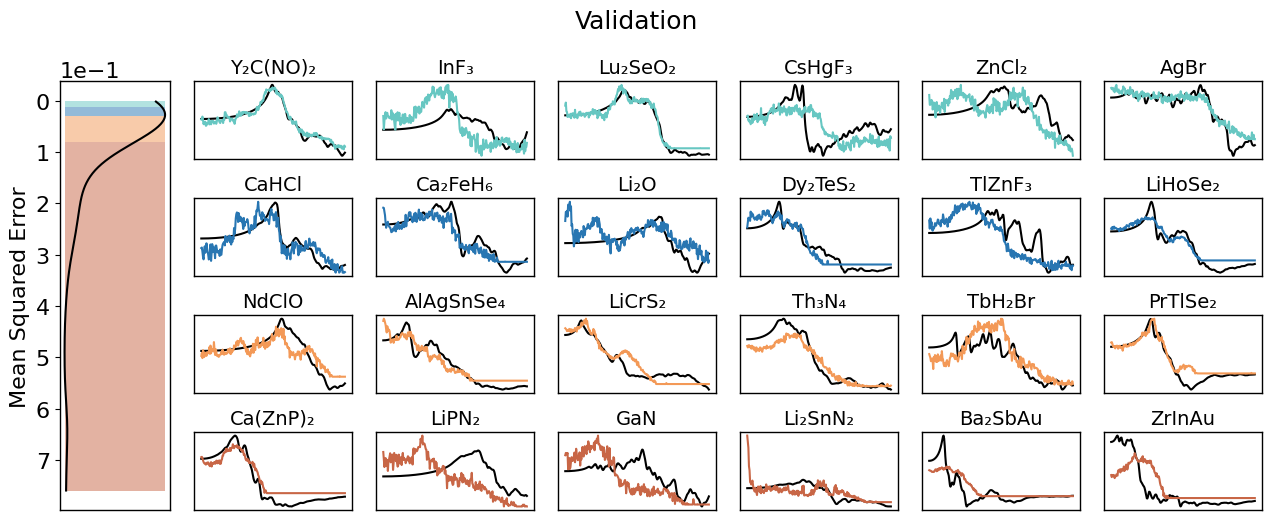

In [79]:
plot_predictions(df, idx_valid, column='real_dielectric_interp', header=run_name, title='Validation')

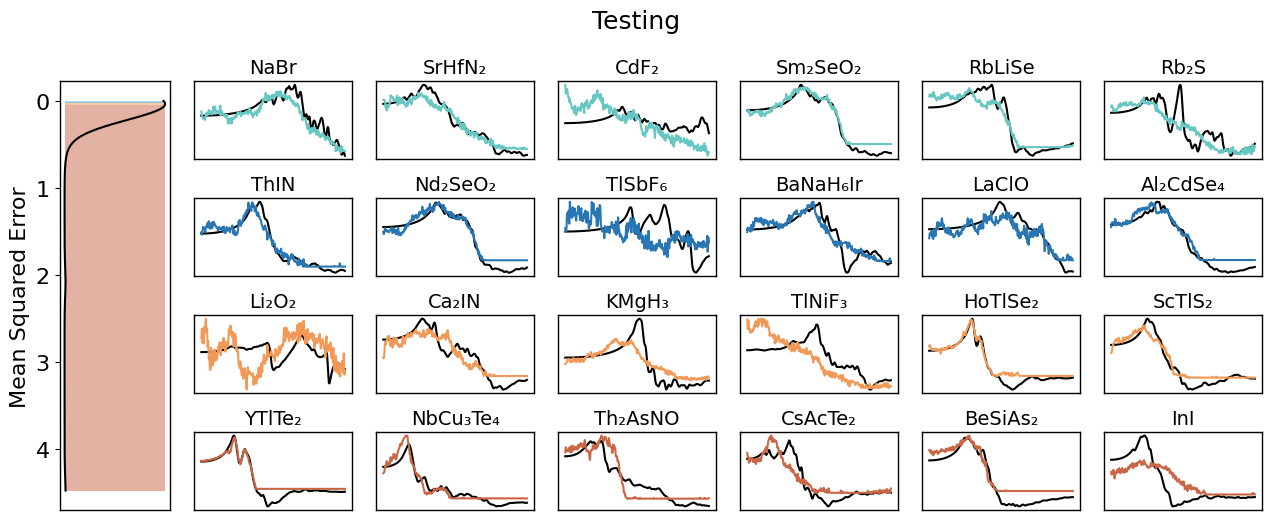

In [80]:
plot_predictions(df, idx_test, column='real_dielectric_interp', header=run_name, title='Testing')

R^2 (Train) = 0.4201 R^2 (Valid) = 0.2739 R^2 (Test) = 0.2023


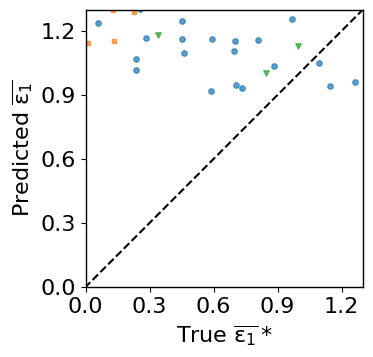

In [74]:
column = 'real_dielectric_interp'

df_tr = df.iloc[idx_train][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_tr = np.array([df_tr.iloc[i]['energies_interp'] for i in range(len(df_tr))])
gt_tr = np.array([df_tr.iloc[i][column] for i in range(len(df_tr))])
pr_tr = np.array([df_tr.iloc[i]['y_pred'] for i in range(len(df_tr))])
# Weighted mean of ground true and predicted values.
wgt_tr = weighted_mean(dx_tr, gt_tr)
wpr_tr = weighted_mean(dx_tr, pr_tr)
# Calculate R^2 value
r2_tr = r2_score(wgt_tr, wpr_tr)

df_va = df.iloc[idx_valid][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_va = np.array([df_va.iloc[i]['energies_interp'] for i in range(len(df_va))])
gt_va = np.array([df_va.iloc[i][column] for i in range(len(df_va))])
pr_va = np.array([df_va.iloc[i]['y_pred'] for i in range(len(df_va))])
# Weighted mean of ground true and predicted values.
wgt_va = weighted_mean(dx_va, gt_va)
wpr_va = weighted_mean(dx_va, pr_va)
# Calculate R^2 value
r2_va = r2_score(wgt_va, wpr_va)

df_te = df.iloc[idx_test][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_te = np.array([df_te.iloc[i]['energies_interp'] for i in range(len(df_te))])
gt_te = np.array([df_te.iloc[i][column] for i in range(len(df_te))])
pr_te = np.array([df_te.iloc[i]['y_pred'] for i in range(len(df_te))])
# Weighted mean of ground true and predicted values.
wgt_te = weighted_mean(dx_te, gt_te)
wpr_te = weighted_mean(dx_te, pr_te)
# Calculate R^2 value
r2_te = r2_score(wgt_te, wpr_te)

print('R^2 (Train) = {:.4f}'.format(r2_tr), 'R^2 (Valid) = {:.4f}'.format(r2_va), 'R^2 (Test) = {:.4f}'.format(r2_te))

# Plot the correction between ground true and predicted values.
fig, ax = plt.subplots(figsize=(4,4))

# Add a diagonal line for reference
min_val = min(np.min(wgt_tr), np.min(wpr_tr), np.min(wgt_va), np.min(wpr_va), np.min(wgt_te), np.min(wpr_te))
max_val = max(np.max(wgt_tr), np.max(wpr_tr), np.max(wgt_va), np.max(wpr_va), np.max(wgt_te), np.max(wpr_te))
width = max_val - min_val
ax.plot([min_val-1, max_val+1], [min_val-1, max_val+1], 'k--', label='Perfect Correlation')

ax.scatter(wgt_tr, wpr_tr, s=15, marker ="o", alpha=0.7, color='C0', label='Train')
ax.scatter(wgt_va, wpr_va, s=12, marker ="s", alpha=0.7, color='C1', label='Valid')
ax.scatter(wgt_te, wpr_te, s=15, marker ="v", alpha=0.7, color='C2', label='Test')

ax.set_xlabel(r'True $\overline{\epsilon_1}*$')
ax.set_ylabel(r'Predicted $\overline{\epsilon_1}$')

#ax.set_xlim(min_val-0.01*width, max_val+0.01*width)
#ax.set_ylim(min_val-0.01*width, max_val+0.01*width)
ax.set_xlim(0.0, 1.3)
ax.set_ylim(0.0, 1.3)
# Set the tick distance
x_ticks = np.arange(0, 1.3, 0.3) 
ax.set_xticks(x_ticks)
y_ticks = np.arange(0, 1.3, 0.3) 
ax.set_yticks(y_ticks)
ax.set_aspect('equal')
#plt.text(0.7, 0.36, r'$R^2$ (Train) = {:.4f}'.format(r2_tr), fontsize = 12, color = 'C0')
#plt.text(0.7, 0.24, r'$R^2$ (Valid) = {:.4f}'.format(r2_va), fontsize = 12, color = 'C1')
#plt.text(0.7, 0.12, r'$R^2$ (Test) = {:.4f}'.format(r2_te), fontsize = 12, color = 'C2')

plt.tight_layout()
fig.savefig(run_name + '_correlation.pdf')

plt.show()

Relative error density (Test) < 10%: 0.34545454545454546


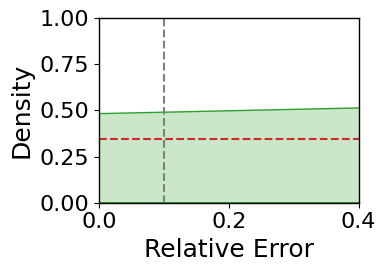

In [75]:
#Relative error between true and predicted values.
error_tr = np.abs(wgt_tr - wpr_tr) / wgt_tr
error_va = np.abs(wgt_va - wpr_va) / wgt_va
error_te = np.abs(wgt_te - wpr_te) / wgt_te

density = np.sum(error_te < 0.10)/len(error_te)
print('Relative error density (Test) < 10%:', density)

#print(error_te)

# Plot relative error density
fig, ax = plt.subplots(figsize=(4,3))
#plt.hist(error_te, bins=200, density=True, alpha=0.7, color='blue')
#plt.hist(error_va, bins=200, density=True, alpha=0.7, color='blue')

#sns.kdeplot(error_tr, fill=True, color='C0', cumulative=True, common_norm=True, label='Relative Error')
#sns.kdeplot(error_va, fill=True, color='C1', cumulative=True, common_norm=True, label='Relative Error')
sns.kdeplot(error_te, fill=True, color='C2', cumulative=True, common_norm=True, label='Relative Error')
#plt.title('Relative Error Density')
plt.axvline(x=0.10,color='gray', linestyle='--')
plt.axhline(y=density, color='C3', linestyle='--')
plt.ylim(0, 1)
plt.xlim(0, 0.4)
plt.xlabel('Relative Error', fontsize = 18)
plt.ylabel('Density', fontsize = 18)
plt.tight_layout()
fig.savefig(run_name + '_error.pdf', transparent=True)
#plt.grid(True)
plt.show()